In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error

In [2]:
FAM0 = pd.read_csv("FehlerA_Messung_0.csv")
FAM1 = pd.read_csv("FehlerA_Messung_1.csv")
FAM2 = pd.read_csv("FehlerA_Messung_2.csv")
FBM0 = pd.read_csv("FehlerB_Messung_0.csv")
FCM0 = pd.read_csv("FehlerC_Messung_0.csv")
FCM1 = pd.read_csv("FehlerC_Messung_1.csv")
FEM0 = pd.read_csv("FehlerE_Messung_0.csv")
FEM1 = pd.read_csv("FehlerE_Messung_1.csv")
FFM0 = pd.read_csv("FehlerF_Messung_0.csv")
FGM0 = pd.read_csv("FehlerG_Messung_0.csv")
FHM0 = pd.read_csv("FehlerH_Messung_0.csv")
FIM0 = pd.read_csv("FehlerI_Messung_0.csv")
OM0 = pd.read_csv("Optimal_Messung_0.csv")
OM1 = pd.read_csv("Optimal_Messung_1.csv")
OM2 = pd.read_csv("Optimal_Messung_2.csv")

In [3]:
datalist = [FAM0, FAM1, FAM2, FBM0, FCM0, FCM1, FEM0, FEM1, FFM0, FGM0, FHM0, FIM0, OM0, OM1, OM2]
data_names = ['FAM0', 'FAM1', 'FAM2', 'FBM0', 'FCM0', 'FCM1', 'FEM0', 'FEM1', 'FFM0', 'FGM0', 'FHM0', 'FIM0', 'OM0', 'OM1', 'OM2']

In [4]:
import scipy

def seperate_holes_advanced(df, treshold=100, skip=200, column='Kraft_N'):

# search for every hole the point where it gets over 250 for the first time
    df_high = df[df['Kraft_N'] > 250]
    high_points = np.asarray(df_high['Zeit_index'])
    high_filter = np.abs(np.diff(np.flip(high_points))) > skip
    high_filter = np.append(high_filter, True)
    high_filter = np.flip(high_filter)
    high_points = high_points[high_filter]

# remove a small area in front of those points
    filter_area = np.ones(len(df), dtype=bool)
    for point in high_points:
        filter_area[df.index[point-200:point]] = False
    df_low = df[filter_area]

# Calculate the indices for the area in which the local minima are determined  
    df_low = df_low[df_low['Kraft_N'] < treshold]
    start_end_points = np.asarray(df_low['Zeit_index'])

    filter_1 = np.diff(start_end_points) > skip
    filter_2 = np.abs(np.diff(np.flip(start_end_points))) > skip
    
    filter_1[0] = True
    filter_1 = np.append(filter_1,True)
    filter_2[0] = True
    filter_2 = np.append(filter_2,True)
    filter_2 = np.flip(filter_2)
    filter = filter_1 + filter_2

    start_end_points = start_end_points[filter]


# Calculate the indices of the local minima of a smooth fitted curve
    df_minimum_indices = np.array([],dtype=int)

    for i,j in zip(start_end_points[::2], start_end_points[1::2]):
        df_minimum_area = df.iloc[i:j]
        vector_minimum_index = np.argmin(scipy.signal.savgol_filter(df_minimum_area['Kraft_N'], len(df_minimum_area['Kraft_N']), 2))
        df_minimum_index = df_minimum_area.index[0] + vector_minimum_index
        df_minimum_indices = np.append(df_minimum_indices, df_minimum_index)
    
    holes = [list(df.iloc[i:j][column]) for i,j in zip(df_minimum_indices[:-1], df_minimum_indices[1:])]

    # remove faulty holes
    for ele in holes:
        if len(ele) > 1500 or len(ele) < 500:
            holes.remove(ele)

    # as df
    # holes = pd.DataFrame(holes).transpose()

    return holes

In [5]:
def plot_holes(holes, alpha=0.005):
    plt.figure(figsize=(15,5))
    for hole in holes:
        plt.plot(np.linspace(0,1000,len(hole)), hole, alpha = alpha, c='b')

Set all vectors to same length.

In [6]:
from scipy.interpolate import interp1d

def interpolate_holes(holes, length = 1000):
    interpolated_vectors = []
    for vector in holes:
        f = interp1d(range(len(vector)), vector, kind='linear')
        interpolated_vector = f(np.linspace(0, len(vector) - 1, length))
        interpolated_vectors.append(interpolated_vector)
    return np.array(interpolated_vectors)

Create training and test sets for autodecoder.

In [7]:
from sklearn.model_selection import train_test_split

OM0_holes = interpolate_holes(seperate_holes_advanced(OM0))
OM1_holes = interpolate_holes(seperate_holes_advanced(OM1))
OM2_holes = interpolate_holes(seperate_holes_advanced(OM2))

x_train1, x_test1 = train_test_split(OM0_holes, test_size=0.2)
x_train2, x_test2 = train_test_split(OM1_holes, test_size=0.2)
x_train3, x_test3 = train_test_split(OM2_holes, test_size=0.2)

x_train = np.concatenate((x_train1, x_train2, x_train3))
x_test = np.concatenate((x_test1, x_test2, x_test3))

Train autoencoder with training set.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 32

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation='relu', input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation='relu'))
autoencoder.add(layers.Dense(128, activation='relu'))
autoencoder.add(layers.Dense(latent_dim, activation='relu'))
autoencoder.add(layers.Dense(128, activation='relu'))
autoencoder.add(layers.Dense(256, activation='relu'))
autoencoder.add(layers.Dense(512, activation='relu'))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=100, batch_size=300, shuffle=True)

Epoch 1/100
26/26 [==============================] - 2s 25ms/step - loss: 5096.6206
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 95.7994
Epoch 3/100
26/26 [==============================] - 1s 30ms/step - loss: 35.2069
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 30.8935
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 30.5844
Epoch 6/100
26/26 [==============================] - 1s 29ms/step - loss: 30.5442
Epoch 7/100
26/26 [==============================] - 1s 27ms/step - loss: 30.5507
Epoch 8/100
26/26 [==============================] - 1s 25ms/step - loss: 30.5553
Epoch 9/100
26/26 [==============================] - 1s 28ms/step - loss: 30.5623
Epoch 10/100
26/26 [==============================] - 1s 28ms/step - loss: 30.5536
Epoch 11/100
26/26 [==============================] - 1s 25ms/step - loss: 30.5562
Epoch 12/100
26/26 [==============================] - 1s 27ms/step - loss: 30.5513
Epoch 13/10

Plot of training set and reconstructed training set.

244/244 [==============================] - 1s 3ms/step


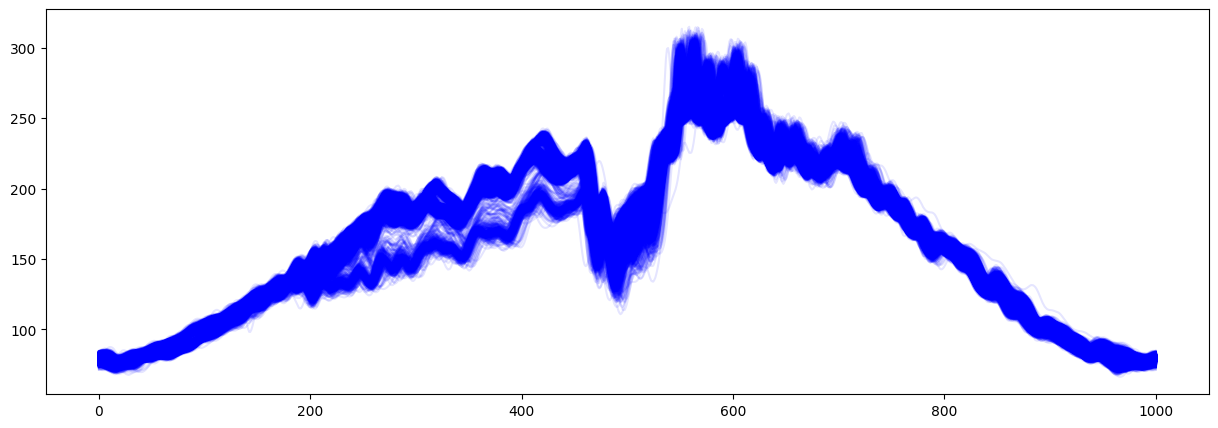

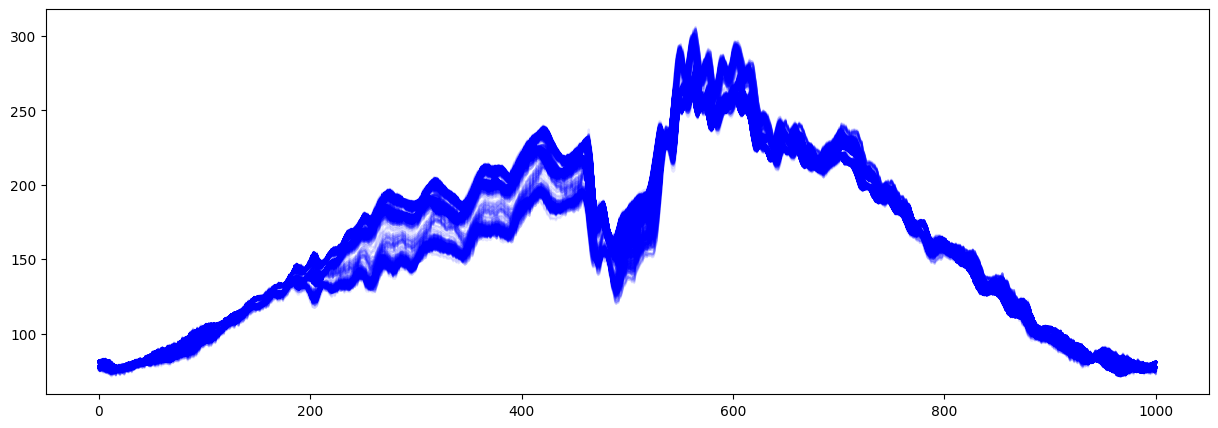

In [9]:
encoder = models.Sequential(autoencoder.layers[:4])
decoder = models.Sequential(autoencoder.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)

plot_holes(x_train, alpha=0.1)
plot_holes(reconstructed_data, alpha=0.1)

Test error:

In [10]:
from sklearn.metrics import mean_squared_error

mean_squared_error(autoencoder.predict(x_test), x_test)

61/61 [==============================] - 0s 4ms/step


7.063431974854352

Data error:


In [11]:
for data,name in zip(datalist, data_names):
    holes = interpolate_holes(seperate_holes_advanced(data))
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))

51/51 [==============================] - 0s 4ms/step
MSE for FAM0: 24.379519071539406
61/61 [==============================] - 0s 4ms/step
MSE for FAM1: 14.955178837849155
60/60 [==============================] - 0s 4ms/step
MSE for FAM2: 17.778507883215653
59/59 [==============================] - 0s 4ms/step
MSE for FBM0: 169.10655618380463
40/40 [==============================] - 0s 4ms/step
MSE for FCM0: 6.85611497446265
45/45 [==============================] - 0s 4ms/step
MSE for FCM1: 11.765789293591405
69/69 [==============================] - 0s 4ms/step
MSE for FEM0: 526.5729932746974
51/51 [==============================] - 0s 4ms/step
MSE for FEM1: 52.13845444568166
75/75 [==============================] - 0s 4ms/step
MSE for FFM0: 11.267806860997592
69/69 [==============================] - 0s 6ms/step
MSE for FGM0: 17.04957082893963
86/86 [==============================] - 0s 4ms/step
MSE for FHM0: 73.27481880944823
66/66 [==============================] - 0s 4ms/step
MSE for

Epoch 1/100
78/78 [==============================] - 3s 18ms/step - loss: 2081.7493
Epoch 2/100
78/78 [==============================] - 1s 19ms/step - loss: 30.8359
Epoch 3/100
78/78 [==============================] - 1s 19ms/step - loss: 30.7287
Epoch 4/100
78/78 [==============================] - 1s 18ms/step - loss: 30.7292
Epoch 5/100
78/78 [==============================] - 1s 19ms/step - loss: 30.8057
Epoch 6/100
78/78 [==============================] - 1s 19ms/step - loss: 30.9129
Epoch 7/100
78/78 [==============================] - 2s 20ms/step - loss: 30.7640
Epoch 8/100
78/78 [==============================] - 1s 19ms/step - loss: 30.8580
Epoch 9/100
78/78 [==============================] - 1s 18ms/step - loss: 30.8664
Epoch 10/100
78/78 [==============================] - 2s 20ms/step - loss: 34.9463
Epoch 11/100
78/78 [==============================] - 1s 19ms/step - loss: 35.5676
Epoch 12/100
78/78 [==============================] - 1s 18ms/step - loss: 36.5773
Epoch 13/10

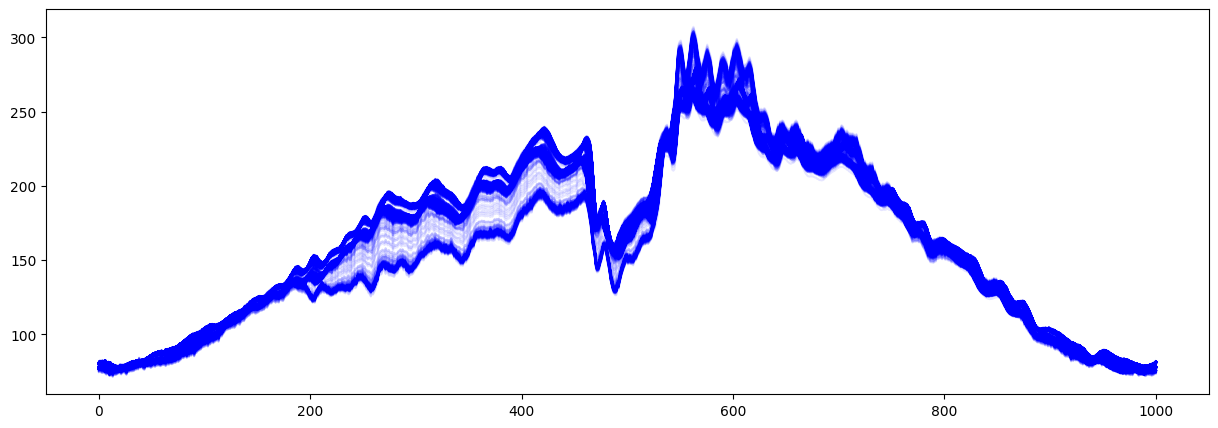

In [12]:
input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation='relu', input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation='relu'))
autoencoder.add(layers.Dense(128, activation='relu'))
autoencoder.add(layers.Dense(64, activation='relu'))
autoencoder.add(layers.Dense(32, activation='relu'))
autoencoder.add(layers.Dense(latent_dim, activation='relu'))
autoencoder.add(layers.Dense(32, activation='relu'))
autoencoder.add(layers.Dense(64, activation='relu'))
autoencoder.add(layers.Dense(128, activation='relu'))
autoencoder.add(layers.Dense(256, activation='relu'))
autoencoder.add(layers.Dense(512, activation='relu'))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=100, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:6])
decoder = models.Sequential(autoencoder.layers[6:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [13]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train), x_train))
print('Test error:', mean_squared_error(autoencoder.predict(x_test), x_test))

51/51 [==============================] - 0s 4ms/step
MSE for FAM0: 28.51367720343301
61/61 [==============================] - 0s 4ms/step
MSE for FAM1: 17.944569046612656
60/60 [==============================] - 0s 6ms/step
MSE for FAM2: 19.960339184569726
59/59 [==============================] - 0s 6ms/step
MSE for FBM0: 189.3442618192424
40/40 [==============================] - 0s 7ms/step
MSE for FCM0: 10.180838807034531
45/45 [==============================] - 0s 6ms/step
MSE for FCM1: 19.71620911309017
69/69 [==============================] - 1s 7ms/step
MSE for FEM0: 531.94162767066
51/51 [==============================] - 0s 7ms/step
MSE for FEM1: 56.373253337523494
75/75 [==============================] - 1s 7ms/step
MSE for FFM0: 19.48124068783153
69/69 [==============================] - 1s 7ms/step
MSE for FGM0: 25.133607264205022
86/86 [==============================] - 1s 7ms/step
MSE for FHM0: 87.57762192071532
66/66 [==============================] - 0s 7ms/step
MSE for F

Epoch 1/50
78/78 [==============================] - 2s 15ms/step - loss: 15815.7822
Epoch 2/50
78/78 [==============================] - 1s 14ms/step - loss: 3211.2812
Epoch 3/50
78/78 [==============================] - 1s 15ms/step - loss: 674.7216
Epoch 4/50
78/78 [==============================] - 1s 14ms/step - loss: 167.1591
Epoch 5/50
78/78 [==============================] - 1s 15ms/step - loss: 65.6195
Epoch 6/50
78/78 [==============================] - 1s 14ms/step - loss: 45.2831
Epoch 7/50
78/78 [==============================] - 1s 15ms/step - loss: 41.2037
Epoch 8/50
78/78 [==============================] - 1s 14ms/step - loss: 40.3849
Epoch 9/50
78/78 [==============================] - 1s 16ms/step - loss: 40.2181
Epoch 10/50
78/78 [==============================] - 1s 14ms/step - loss: 40.1866
Epoch 11/50
78/78 [==============================] - 1s 15ms/step - loss: 40.1788
Epoch 12/50
78/78 [==============================] - 1s 14ms/step - loss: 40.1787
Epoch 13/50
78/78 

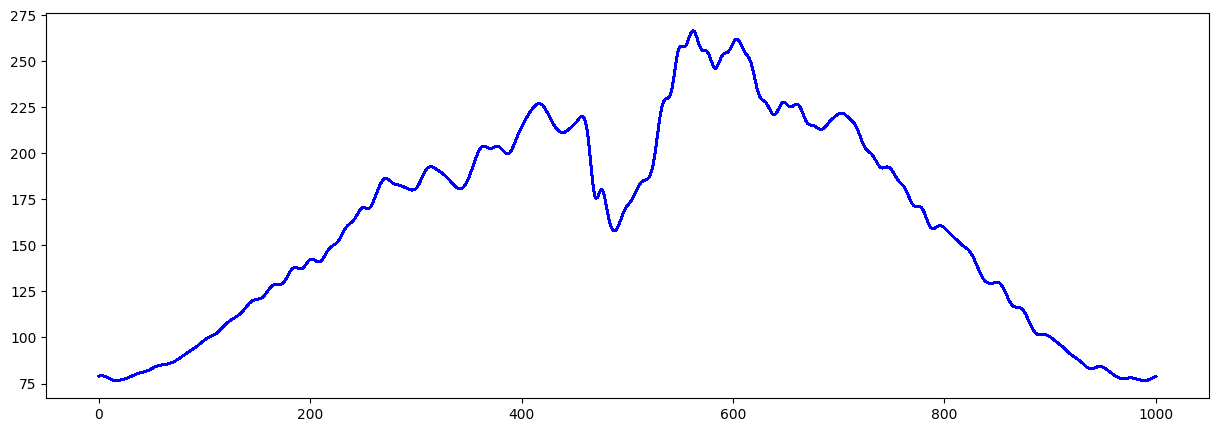

In [112]:
input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 32

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation='sigmoid', input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation='sigmoid'))
autoencoder.add(layers.Dense(128, activation='sigmoid'))
autoencoder.add(layers.Dense(latent_dim, activation='sigmoid'))
autoencoder.add(layers.Dense(128, activation='sigmoid'))
autoencoder.add(layers.Dense(256, activation='sigmoid'))
autoencoder.add(layers.Dense(512, activation='sigmoid'))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='sgd', loss='mse')
autoencoder.fit(input_data, input_data, epochs=50, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:4])
decoder = models.Sequential(autoencoder.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [15]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train), x_train))
print('Test error:', mean_squared_error(autoencoder.predict(x_test), x_test))

51/51 [==============================] - 1s 8ms/step
MSE for FAM0: 37.07236665223384
61/61 [==============================] - 0s 7ms/step
MSE for FAM1: 43.160238185942866
60/60 [==============================] - 0s 8ms/step
MSE for FAM2: 46.750024754619346
59/59 [==============================] - 1s 8ms/step
MSE for FBM0: 271.3001634656304
40/40 [==============================] - 0s 7ms/step
MSE for FCM0: 43.21635145246785
45/45 [==============================] - 0s 8ms/step
MSE for FCM1: 54.81508352484721
69/69 [==============================] - 1s 7ms/step
MSE for FEM0: 863.7454197811226
51/51 [==============================] - 0s 7ms/step
MSE for FEM1: 88.1850531968727
75/75 [==============================] - 1s 7ms/step
MSE for FFM0: 46.79159826843237
69/69 [==============================] - 1s 8ms/step
MSE for FGM0: 64.42635338737107
86/86 [==============================] - 1s 8ms/step
MSE for FHM0: 168.0610637498064
66/66 [==============================] - 1s 8ms/step
MSE for FIM

Epoch 1/200
78/78 [==============================] - 6s 28ms/step - loss: 1926.9896
Epoch 2/200
78/78 [==============================] - 2s 29ms/step - loss: 30.9093
Epoch 3/200
78/78 [==============================] - 2s 27ms/step - loss: 30.7783
Epoch 4/200
78/78 [==============================] - 2s 28ms/step - loss: 30.8036
Epoch 5/200
78/78 [==============================] - 2s 28ms/step - loss: 30.8029
Epoch 6/200
78/78 [==============================] - 2s 28ms/step - loss: 30.8058
Epoch 7/200
78/78 [==============================] - 2s 28ms/step - loss: 32.2271
Epoch 8/200
78/78 [==============================] - 2s 28ms/step - loss: 40.7776
Epoch 9/200
78/78 [==============================] - 2s 27ms/step - loss: 40.9360
Epoch 10/200
78/78 [==============================] - 2s 27ms/step - loss: 31.5190
Epoch 11/200
78/78 [==============================] - 2s 28ms/step - loss: 48.4356
Epoch 12/200
78/78 [==============================] - 2s 28ms/step - loss: 30.9988
Epoch 13/20

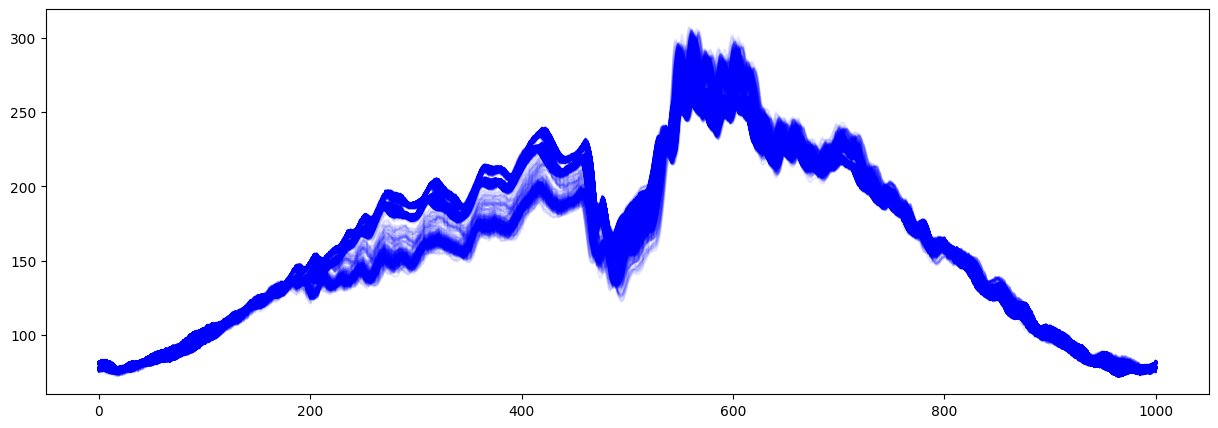

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=200, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:6])
decoder = models.Sequential(autoencoder.layers[6:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [17]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train), x_train))
print('Test error:', mean_squared_error(autoencoder.predict(x_test), x_test))

51/51 [==============================] - 1s 8ms/step
MSE for FAM0: 22.528897831258227
61/61 [==============================] - 1s 8ms/step
MSE for FAM1: 16.79074857728814
60/60 [==============================] - 1s 9ms/step
MSE for FAM2: 18.9817684116521
59/59 [==============================] - 1s 8ms/step
MSE for FBM0: 142.34238120909416
40/40 [==============================] - 0s 8ms/step
MSE for FCM0: 7.734494306452642
45/45 [==============================] - 0s 8ms/step
MSE for FCM1: 11.069271740515987
69/69 [==============================] - 1s 8ms/step
MSE for FEM0: 686.4950310241654
51/51 [==============================] - 0s 8ms/step
MSE for FEM1: 52.86097687621006
75/75 [==============================] - 1s 8ms/step
MSE for FFM0: 9.692442191165709
69/69 [==============================] - 1s 8ms/step
MSE for FGM0: 16.202717391999734
86/86 [==============================] - 1s 8ms/step
MSE for FHM0: 60.882504862919966
66/66 [==============================] - 1s 7ms/step
MSE for 

Epoch 1/50
78/78 [==============================] - 5s 27ms/step - loss: 1764.8829
Epoch 2/50
78/78 [==============================] - 2s 27ms/step - loss: 30.9941
Epoch 3/50
78/78 [==============================] - 2s 26ms/step - loss: 30.8530
Epoch 4/50
78/78 [==============================] - 2s 26ms/step - loss: 32.9571
Epoch 5/50
78/78 [==============================] - 2s 27ms/step - loss: 37.3747
Epoch 6/50
78/78 [==============================] - 2s 27ms/step - loss: 32.4314
Epoch 7/50
78/78 [==============================] - 2s 27ms/step - loss: 34.6618
Epoch 8/50
78/78 [==============================] - 2s 26ms/step - loss: 36.7387
Epoch 9/50
78/78 [==============================] - 2s 26ms/step - loss: 36.7720
Epoch 10/50
78/78 [==============================] - 2s 27ms/step - loss: 32.2567
Epoch 11/50
78/78 [==============================] - 2s 26ms/step - loss: 34.3004
Epoch 12/50
78/78 [==============================] - 2s 29ms/step - loss: 39.9803
Epoch 13/50
78/78 [====

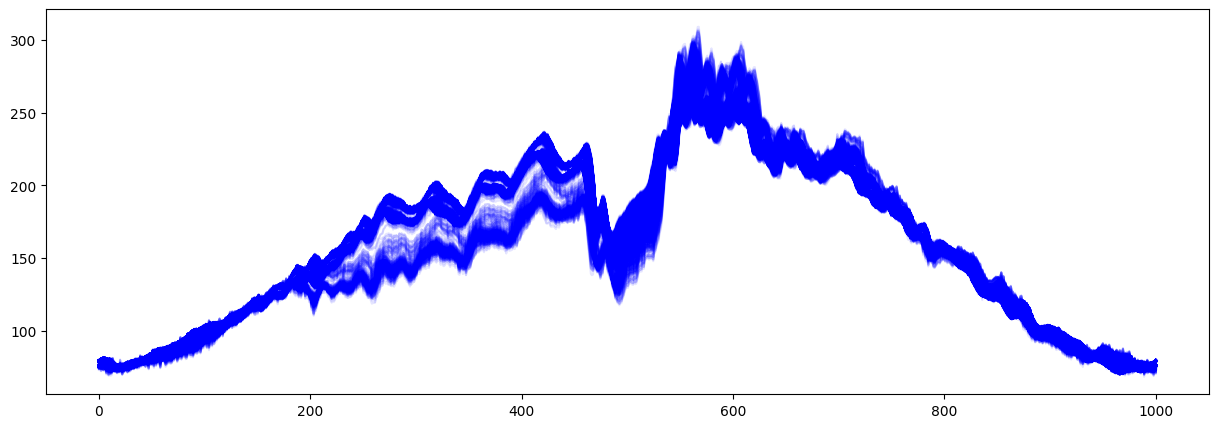

In [18]:
input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=50, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:4])
decoder = models.Sequential(autoencoder.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [19]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train), x_train))
print('Test error:', mean_squared_error(autoencoder.predict(x_test), x_test))

51/51 [==============================] - 1s 9ms/step
MSE for FAM0: 27.39853844650538
61/61 [==============================] - 1s 9ms/step
MSE for FAM1: 23.017362493590824
60/60 [==============================] - 1s 9ms/step
MSE for FAM2: 26.21268684060643
59/59 [==============================] - 1s 8ms/step
MSE for FBM0: 152.50495333568108
40/40 [==============================] - 0s 5ms/step
MSE for FCM0: 14.129765662768909
45/45 [==============================] - 0s 4ms/step
MSE for FCM1: 16.531312880887715
69/69 [==============================] - 11s 163ms/step
MSE for FEM0: 554.1385279617766
51/51 [==============================] - 0s 6ms/step
MSE for FEM1: 60.14070418733341
75/75 [==============================] - 0s 5ms/step
MSE for FFM0: 15.29931486884273
69/69 [==============================] - 0s 5ms/step
MSE for FGM0: 23.098845777942557
86/86 [==============================] - 0s 5ms/step
MSE for FHM0: 63.51378543260449
66/66 [==============================] - 0s 5ms/step
MSE 

Epoch 1/50
78/78 [==============================] - 3s 20ms/step - loss: 9.3255e-05
Epoch 2/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0633e-06
Epoch 3/50
78/78 [==============================] - 2s 19ms/step - loss: 1.0571e-06
Epoch 4/50
78/78 [==============================] - 1s 19ms/step - loss: 1.0574e-06
Epoch 5/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0574e-06
Epoch 6/50
78/78 [==============================] - 2s 19ms/step - loss: 1.0586e-06
Epoch 7/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0569e-06
Epoch 8/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0568e-06
Epoch 9/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0573e-06
Epoch 10/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0567e-06
Epoch 11/50
78/78 [==============================] - 2s 20ms/step - loss: 1.0576e-06
Epoch 12/50
78/78 [==============================] - 2s 19ms/step - loss: 

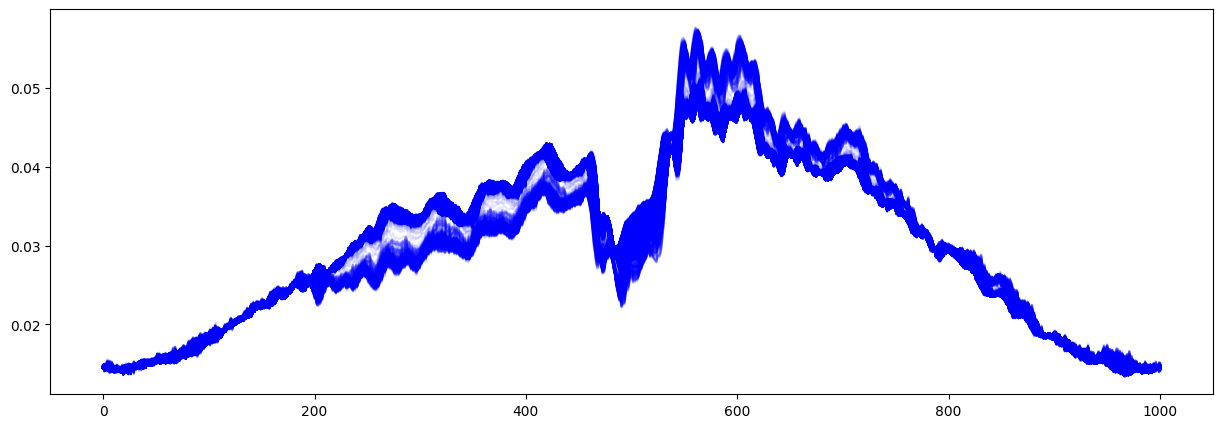

In [20]:
from sklearn import preprocessing

input_data = preprocessing.normalize(x_train)
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=50, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:4])
decoder = models.Sequential(autoencoder.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [22]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    holes = preprocessing.normalize(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))

print('Training error:', mean_squared_error(autoencoder.predict(preprocessing.normalize(x_train)), preprocessing.normalize(x_train)))
print('Test error:', mean_squared_error(autoencoder.predict(preprocessing.normalize(x_test)), preprocessing.normalize(x_test)))

51/51 [==============================] - 0s 4ms/step
MSE for FAM0: 9.09975000603073e-07
61/61 [==============================] - 0s 4ms/step
MSE for FAM1: 5.019762074122751e-07
60/60 [==============================] - 0s 5ms/step
MSE for FAM2: 5.995981439032854e-07
59/59 [==============================] - 0s 4ms/step
MSE for FBM0: 5.651900413268943e-06
40/40 [==============================] - 0s 4ms/step
MSE for FCM0: 2.420175894942905e-07
45/45 [==============================] - 0s 4ms/step
MSE for FCM1: 3.9398662084213187e-07
69/69 [==============================] - 0s 4ms/step
MSE for FEM0: 2.0356558568306652e-05
51/51 [==============================] - 0s 4ms/step
MSE for FEM1: 1.8525792296486938e-06
75/75 [==============================] - 0s 4ms/step
MSE for FFM0: 4.5052280920058885e-07
69/69 [==============================] - 0s 4ms/step
MSE for FGM0: 6.207848933929778e-07
86/86 [==============================] - 0s 4ms/step
MSE for FHM0: 2.4382250413852834e-06
66/66 [==========

In [23]:
OM0_holes = interpolate_holes(seperate_holes_advanced(OM0, column='DMS1_um/m'))
OM1_holes = interpolate_holes(seperate_holes_advanced(OM1, column='DMS1_um/m'))
OM2_holes = interpolate_holes(seperate_holes_advanced(OM2, column='DMS1_um/m'))

x_train1, x_test1 = train_test_split(OM0_holes, test_size=0.2)
x_train2, x_test2 = train_test_split(OM1_holes, test_size=0.2)
x_train3, x_test3 = train_test_split(OM2_holes, test_size=0.2)

x_train2 = np.concatenate((x_train1, x_train2, x_train3))
x_test2 = np.concatenate((x_test1, x_test2, x_test3))

Epoch 1/50
78/78 [==============================] - 3s 20ms/step - loss: 278.6736
Epoch 2/50
78/78 [==============================] - 1s 19ms/step - loss: 8.0429
Epoch 3/50
78/78 [==============================] - 1s 19ms/step - loss: 8.0259
Epoch 4/50
78/78 [==============================] - 2s 19ms/step - loss: 9.0368
Epoch 5/50
78/78 [==============================] - 1s 18ms/step - loss: 8.0519
Epoch 6/50
78/78 [==============================] - 2s 20ms/step - loss: 8.7660
Epoch 7/50
78/78 [==============================] - 1s 19ms/step - loss: 8.9311
Epoch 8/50
78/78 [==============================] - 1s 19ms/step - loss: 8.8590
Epoch 9/50
78/78 [==============================] - 2s 20ms/step - loss: 8.5445
Epoch 10/50
78/78 [==============================] - 2s 19ms/step - loss: 19.8549
Epoch 11/50
78/78 [==============================] - 2s 19ms/step - loss: 8.5661
Epoch 12/50
78/78 [==============================] - 2s 20ms/step - loss: 7.1794
Epoch 13/50
78/78 [===============

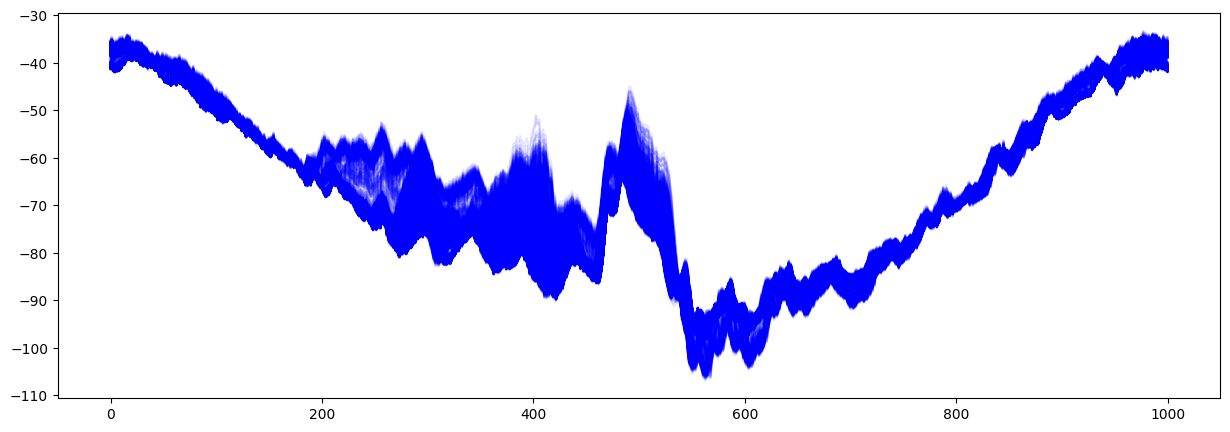

In [24]:
input_data = x_train2
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=50, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:4])
decoder = models.Sequential(autoencoder.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [26]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data, column='DMS1_um/m')
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train2), x_train2))
print('Test error:', mean_squared_error(autoencoder.predict(x_test2), x_test2))

51/51 [==============================] - 0s 5ms/step
MSE for FAM0: 3.855660909192763
61/61 [==============================] - 0s 5ms/step
MSE for FAM1: 2.789147770024201
60/60 [==============================] - 0s 5ms/step
MSE for FAM2: 3.0693694543370498
59/59 [==============================] - 0s 5ms/step
MSE for FBM0: 24.549380824649976
40/40 [==============================] - 0s 6ms/step
MSE for FCM0: 1.7934688370879228
45/45 [==============================] - 0s 5ms/step
MSE for FCM1: 2.268991387589241
69/69 [==============================] - 0s 5ms/step
MSE for FEM0: 71.73989235728723
51/51 [==============================] - 0s 5ms/step
MSE for FEM1: 10.23159058701426
75/75 [==============================] - 0s 5ms/step
MSE for FFM0: 5.297238682778643
69/69 [==============================] - 0s 6ms/step
MSE for FGM0: 4.710370470773711
86/86 [==============================] - 0s 5ms/step
MSE for FHM0: 9.909702122258247
66/66 [==============================] - 0s 5ms/step
MSE for F

In [28]:
OM0_holes = interpolate_holes(seperate_holes_advanced(OM0))
OM1_holes = interpolate_holes(seperate_holes_advanced(OM1))
OM2_holes = interpolate_holes(seperate_holes_advanced(OM2))
OM_holes = np.concatenate((OM0_holes, OM1_holes, OM2_holes))

mean_curve = np.mean(OM_holes, axis=0)

1000

In [98]:
import keras.backend as K
square_error = np.mean((OM_holes-mean_curve)**2, axis=1)
mse = np.mean((OM_holes-mean_curve)**2)
mask1 = square_error < 5*mse
mask2 = square_error >= 5*mse

main_curve = OM_holes[mask1]
side_curve = OM_holes[mask2]

x_train3, x_test3 = train_test_split(main_curve, test_size=0.2)
x_train4, x_test4 = train_test_split(side_curve, test_size=0.2)

Epoch 1/50
75/75 [==============================] - 3s 25ms/step - loss: 1866.9047
Epoch 2/50
75/75 [==============================] - 2s 24ms/step - loss: 20.5914
Epoch 3/50
75/75 [==============================] - 2s 24ms/step - loss: 20.4366
Epoch 4/50
75/75 [==============================] - 2s 24ms/step - loss: 20.3994
Epoch 5/50
75/75 [==============================] - 2s 25ms/step - loss: 20.4526
Epoch 6/50
75/75 [==============================] - 2s 26ms/step - loss: 21.6142
Epoch 7/50
75/75 [==============================] - 2s 26ms/step - loss: 24.9398
Epoch 8/50
75/75 [==============================] - 2s 26ms/step - loss: 22.1739
Epoch 9/50
75/75 [==============================] - 2s 26ms/step - loss: 25.3909
Epoch 10/50
75/75 [==============================] - 2s 25ms/step - loss: 25.2280
Epoch 11/50
75/75 [==============================] - 2s 25ms/step - loss: 21.8181
Epoch 12/50
75/75 [==============================] - 2s 25ms/step - loss: 31.6144
Epoch 13/50
75/75 [====

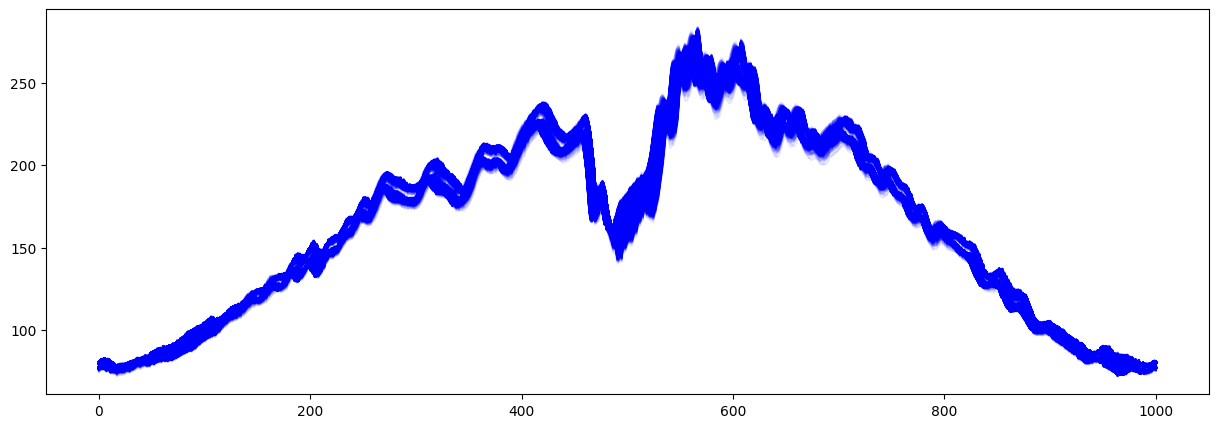

In [101]:
input_data = x_train3
input_dim = input_data.shape[1]
latent_dim = 16

autoencoder_main = models.Sequential()

autoencoder_main.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder_main.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_main.add(layers.Dense(input_dim, activation='linear'))

autoencoder_main.compile(optimizer='adam', loss='mse')
autoencoder_main.fit(input_data, input_data, epochs=50, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder_main.layers[:4])
decoder = models.Sequential(autoencoder_main.layers[4:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

Epoch 1/100
3/3 [==============================] - 2s 20ms/step - loss: 25432.1582
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 11536.4385
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 2997.4397
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 1627.3932
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 1298.1927
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 997.9514
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 651.0101
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 410.4720
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 249.5299
Epoch 10/100
3/3 [==============================] - 0s 22ms/step - loss: 184.4095
Epoch 11/100
3/3 [==============================] - 0s 22ms/step - loss: 148.3170
Epoch 12/100
3/3 [==============================] - 0s 27ms/step - loss: 114.8776
Epoch 13/100
3/3 [

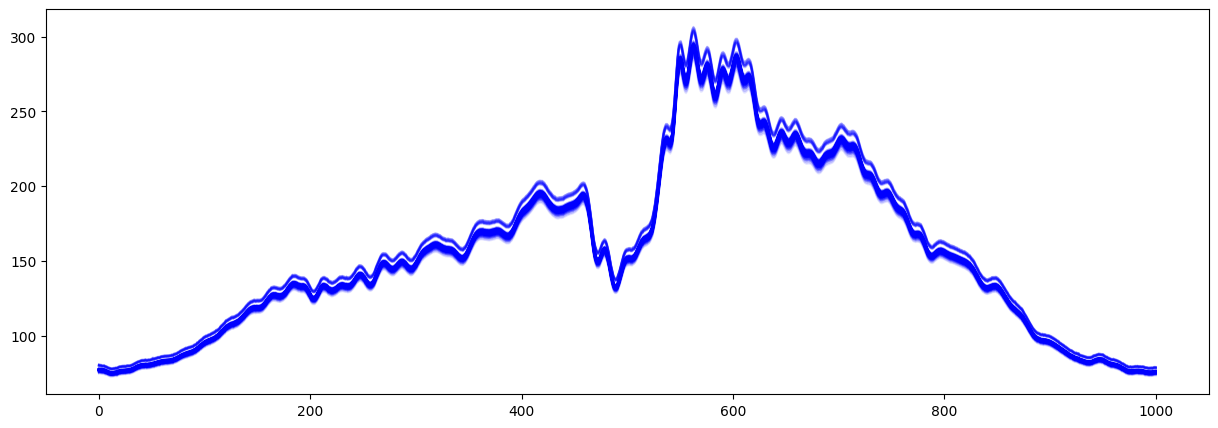

In [108]:
input_data = x_train4
input_dim = input_data.shape[1]
latent_dim = 8

autoencoder_side = models.Sequential()

autoencoder_side.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder_side.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder_side.add(layers.Dense(input_dim, activation='linear'))

autoencoder_side.compile(optimizer='adam', loss='mse')
autoencoder_side.fit(input_data, input_data, epochs=100, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder_side.layers[:5])
decoder = models.Sequential(autoencoder_side.layers[5:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [111]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse_1 = np.mean((autoencoder_main.predict(holes)-holes)**2, axis=1)
    mse_2 = np.mean((autoencoder_side.predict(holes)-holes)**2, axis=1)
    mse = np.mean(np.minimum(mse_1, mse_2))
    print('MSE for {}: {}'.format(name, mse))

51/51 [==============================] - 0s 5ms/step
MSE for FAM0: 28.23816287142041
61/61 [==============================] - 0s 5ms/step
MSE for FAM1: 15.95245697553182
60/60 [==============================] - 0s 5ms/step
MSE for FAM2: 18.49744977979577
59/59 [==============================] - 0s 5ms/step
MSE for FBM0: 152.24043084010037
40/40 [==============================] - 0s 5ms/step
MSE for FCM0: 7.633161811669231
45/45 [==============================] - 0s 5ms/step
MSE for FCM1: 12.1001078255618
69/69 [==============================] - 0s 6ms/step
MSE for FEM0: 537.262921021363
51/51 [==============================] - 0s 5ms/step
MSE for FEM1: 55.88562935930809
75/75 [==============================] - 0s 5ms/step
MSE for FFM0: 13.20688945044961
69/69 [==============================] - 0s 5ms/step
MSE for FGM0: 21.99905421225028
86/86 [==============================] - 0s 5ms/step
MSE for FHM0: 61.92117489483736
66/66 [==============================] - 0s 5ms/step
MSE for FIM0:

Epoch 1/200
78/78 [==============================] - 4s 29ms/step - loss: 1762.1300
Epoch 2/200
78/78 [==============================] - 2s 28ms/step - loss: 30.7559
Epoch 3/200
78/78 [==============================] - 2s 29ms/step - loss: 30.6381
Epoch 4/200
78/78 [==============================] - 2s 28ms/step - loss: 43.0738
Epoch 5/200
78/78 [==============================] - 2s 28ms/step - loss: 30.6227
Epoch 6/200
78/78 [==============================] - 2s 28ms/step - loss: 48.0581
Epoch 7/200
78/78 [==============================] - 2s 29ms/step - loss: 32.1801
Epoch 8/200
78/78 [==============================] - 2s 28ms/step - loss: 30.0866
Epoch 9/200
78/78 [==============================] - 2s 29ms/step - loss: 34.7293
Epoch 10/200
78/78 [==============================] - 2s 29ms/step - loss: 45.7275
Epoch 11/200
78/78 [==============================] - 2s 29ms/step - loss: 27.9862
Epoch 12/200
78/78 [==============================] - 2s 29ms/step - loss: 26.3155
Epoch 13/20

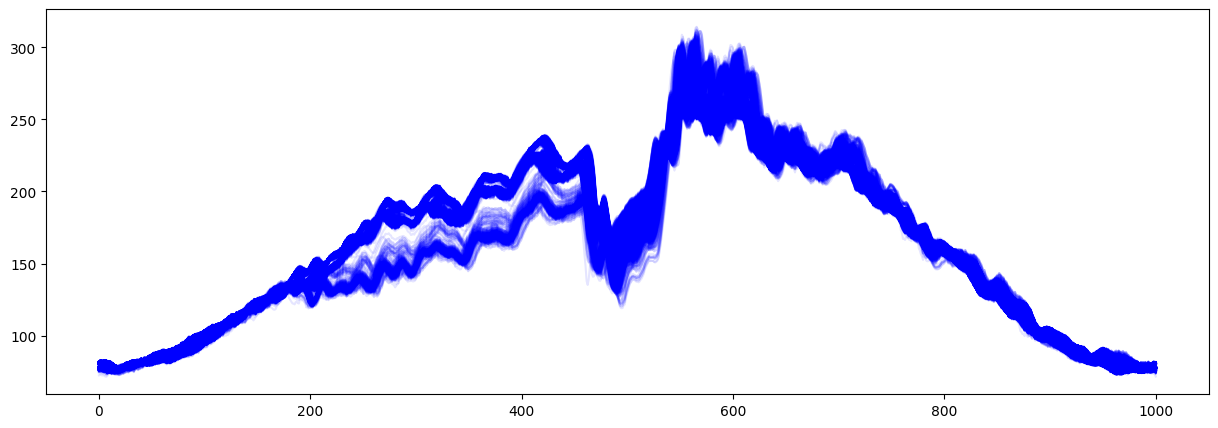

In [114]:
input_data = x_train
input_dim = input_data.shape[1]
latent_dim = 64

autoencoder = models.Sequential()

autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=input_dim))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
autoencoder.add(layers.Dense(input_dim, activation='linear'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_data, input_data, epochs=200, batch_size=100, shuffle=True)

encoder = models.Sequential(autoencoder.layers[:6])
decoder = models.Sequential(autoencoder.layers[6:])
compressed_data = encoder.predict(input_data)
reconstructed_data = decoder.predict(compressed_data)
plot_holes(reconstructed_data, alpha=0.1)

In [115]:
for data,name in zip(datalist, data_names):
    holes = seperate_holes_advanced(data)
    holes = interpolate_holes(holes)
    mse = mean_squared_error(autoencoder.predict(holes), holes)
    print('MSE for {}: {}'.format(name, mse))
print('Training error:', mean_squared_error(autoencoder.predict(x_train), x_train))
print('Test error:', mean_squared_error(autoencoder.predict(x_test), x_test))

51/51 [==============================] - 1s 10ms/step
MSE for FAM0: 15.599446888050775
61/61 [==============================] - 1s 10ms/step
MSE for FAM1: 13.473588030943596
60/60 [==============================] - 1s 10ms/step
MSE for FAM2: 15.970251493567277
59/59 [==============================] - 1s 11ms/step
MSE for FBM0: 135.69538957515744
40/40 [==============================] - 0s 10ms/step
MSE for FCM0: 4.7383742210774855
45/45 [==============================] - 0s 10ms/step
MSE for FCM1: 5.9448106727817285
69/69 [==============================] - 1s 10ms/step
MSE for FEM0: 635.5015697572143
51/51 [==============================] - 1s 10ms/step
MSE for FEM1: 38.28492553216207
75/75 [==============================] - 1s 10ms/step
MSE for FFM0: 5.533313481710705
69/69 [==============================] - 1s 10ms/step
MSE for FGM0: 11.610134343393398
86/86 [==============================] - 1s 10ms/step
MSE for FHM0: 43.55862243566954
66/66 [==============================] - 1s 10m